#Amy Pitts
##DATA 440
###May 13, 2019


###Creating the dataset

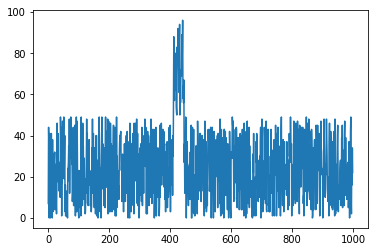

In [0]:
###Setting the dataset 
import random as r
import numpy as np
import matplotlib.pyplot as plt

length = 1000 #defining the number of datapoints in the set
iterations = 10 #changing the number of iterations. not to high please 

master_data = []
master_breaks = []

#I ran into a problem of the set of breaks was not in sense of time but 
#just number of datapoints in that set 
def add_one_by_one(l):
    new_l = []
    count = 0
    for elt in l:
        count += elt
        new_l.append(count)
    return new_l

#creating the data. 1-10 breaks for each iteration 
for x in range(iterations):
  for y in range(10):
    num_of_breaks = y+1
  
    s=[]
    for x in range(num_of_breaks):
      s.append( r.randint(5,round(length/(num_of_breaks))))
    s.append(length-sum(s)) #making sure the data is the right length

    numbers = []
    for x in range(num_of_breaks+1):
      #every other set should have 0-50 and 50-100 datapoint values
      if(x%2 == 0):
        l = np.random.randint(0,50,s[x])  
      else:
        l = np.random.randint(50,100,s[x]) 
      numbers = numbers + [*l]
    master_data.append(numbers) #saving that dataset
    breaks = add_one_by_one(s) #changing the breakpoints
    master_breaks.append(breaks) #saving the breakpoints 

#testing my creation     
plt.plot(master_data[1])
master_breaks[1]


#Putting the data into matrices 
x = np.zeros((len(master_data), length, length), dtype=np.bool)
y = np.zeros((len(master_breaks), 1, length), dtype=np.bool)

for j in range(len(master_data)-1):
  y_temp = np.zeros((1,length))
  for i in range(len(master_breaks[j])-1):
    y_temp[0,master_breaks[j][i]] = 1
  y[j] = y_temp

  x_temp = np.zeros((length, length))
  for i in range(length):
    x_temp[i,master_data[j][i] ] = 1
  x[j] = x_temp



#The Neural Network 

In [0]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import random as r
import matplotlib.pyplot as plt
  
# --------- Defining the Data -----------
length = 500 #defining the number of datapoints in the set
iterations = 100 #changing the number of iterations. dataset size = interations*10

seq_len = 10 #Setting the sequence length


# Setting the breakpoints in sense of time rather then just the index
def add_one_by_one(l):
    new_l = []
    count = 0
    for elt in l:
        count += elt
        new_l.append(count)
    return new_l

#creating the data. 1-10 breaks for each iteration 
Data = np.zeros((iterations*10,length))
DataB= np.zeros((iterations*10,length))

rowCnt = 0
for x in range(iterations):
  for y in range(10):
    num_of_breaks = y+1
  
    s=[]
    for x in range(num_of_breaks):
      s.append( r.randint(5, round(length/(num_of_breaks))))
    s.append(length-sum(s)) #making sure the data is the right length

    numbers = []
    for x in range(num_of_breaks+1):
      #every other set should have 0-50 and 50-100 datapoint values
      if(x%2 == 0):
        l = np.random.randint(0,50,s[x])  
      else:
        l = np.random.randint(50,100,s[x]) 
      numbers = numbers + [*l]
    Data[rowCnt] = np.array(numbers)#saving that dataset
    breaks = add_one_by_one(s) #changing the breakpoints

    for ppp in range(len(breaks) - 1):
      idx = breaks[ppp]
      DataB[rowCnt,idx] = 1 #saving the breakpoints 
    rowCnt += 1
#-------------------------------------------

print('Vectorization...')

DataSeq = np.zeros((Data.shape[0]*((length - seq_len) + 1), seq_len))
DataBSeq = np.zeros((DataB.shape[0]*((length - seq_len) + 1), seq_len))

rowCnt = 0
idxLst = []

for row in range(Data.shape[0]):
  for idx in range(Data.shape[1]-seq_len):
    DataSeq[rowCnt] = Data[row,idx:idx+seq_len]
    DataBSeq[rowCnt] = DataB[row,idx:idx+seq_len]
    if np.sum(DataBSeq[rowCnt])>0:
      idxLst.append(rowCnt)
    rowCnt += 1
    
DataSeq  = DataSeq[idxLst,:]
DataBSeq = DataBSeq[idxLst,:]


print('Total breakpoint datasets:', rowCnt) 

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(DataBSeq))
np.random.shuffle(indices)
DataSeq = DataSeq[indices]
DataBSeq = DataBSeq[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(DataSeq) - len(DataSeq) // 10
x_train, x_val = DataSeq[:split_at], DataSeq[split_at:]
y_train, y_val = DataBSeq[:split_at], DataBSeq[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)


# Try replacing GRU, or SimpleRNN.
NEURONS = 128 #512 #256 #64  
LAYERS = 1 

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(layers.Dense(NEURONS, input_dim=seq_len))
model.add(layers.Dropout(0.25))


# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.Dense(seq_len, activation='sigmoid'))
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset. 
for iteration in range(1, 100):
  print()
  print('-' * 50)
  print('Iteration', iteration)
  model.fit(x_train, y_train,
            batch_size=NEURONS,
            epochs=1,
            validation_data=(x_val, y_val))


Using TensorFlow backend.


Vectorization...
Total breakpoint datasets: 490000
Training Data:
(48470, 10)
(48470, 10)
Validation Data:
(5385, 10)
(5385, 10)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
Instructi

##Predicting

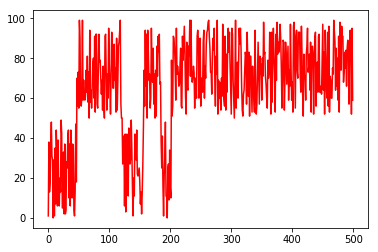

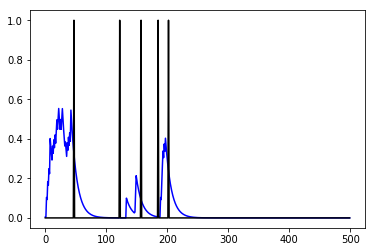

In [0]:
sample = 74
test = Data[sample,:]
out = np.zeros(test.shape)

for idx in range(test.shape[0]-seq_len):
#   print(test[idx:idx+5])
#   print(test[idx:idx+5].shape)
#   print(model.predict(np.reshape(test[idx:idx+5], (1,seq_len))))
  
  out[idx:idx+seq_len] = np.mean(out[idx:idx+seq_len] + model.predict(np.reshape(test[idx:idx+seq_len], (1,seq_len))))
  #out[idx:idx+seq_len] = out[idx:idx+seq_len] + model.predict(np.reshape(test[idx:idx+seq_len], (1,seq_len)))
  
  
plt.plot(test,'r-')
plt.show()

plt.plot(out,'b-')
plt.plot(DataB[sample,:],'k-')
plt.show()

##Pelican Data


In [0]:
pelicans = [0.2675, 0.3266, 0.8722, 1.6571, 0.2269, 0.2150, 0.4939, 0.4633, 2.0651,
            1.0819, 0.3096, 1.0729, 0.6532, 0.4614, 0.2762, 0.2622, 0.2985, 0.3661, 
            0.6439, 0.4053, 0.3172, 0.1481, 0.1016, 0.0481, 0.1677, 0.5236, 0.1816,
            0.7234, 0.5313, 0.3814, 0.3668, 0.1979, 0.2590, 0.1138, 0.1276, 0.056,
            0.0911, 0.1454, 0.2320, 0.2979, 0.1628, 0.1330, 0.0694, 0.3253, 0.2286,
            0.2812, 0.0789, 0.0420, 0.1658, 0.3842, 0.2664, 0.4230, 0.5684, 0.422, 
            0.4240, 0.3247, 0.4129, 0.4609, 0.6533, 0.5962, 0.6573, 0.4820, 0.4225,
            0.4678, 0.5435, 0.6789, 0.8439, 0.7187, 0.9592, 0.7311, 1.1591, 0.8641,
            0.5325, 0.4097, 0.4674, 0.4253, 0.4849, 0.5527, 0.5915]
print(len(pelicans))

79


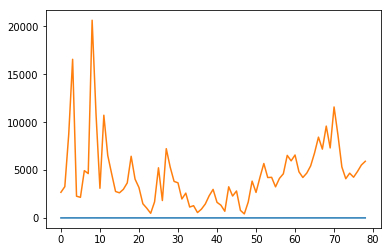

In [0]:
plt.plot(pelicans)
#Releveling the data 
new_pelicans = [int (np.round(i * 10000)) for i in pelicans]
plt.plot(new_pelicans)


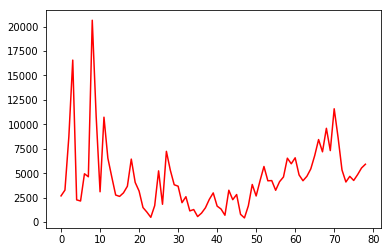

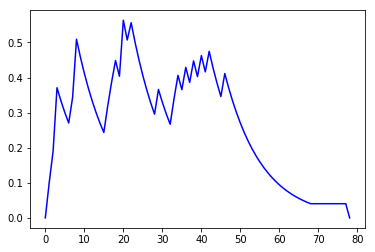

In [0]:
new_pelicans = [int (np.round(i * 10000)) for i in pelicans]
test = new_pelicans
out = np.zeros(len(test))

for idx in range(len(test)-seq_len):
  out[idx:idx+seq_len] = np.mean(out[idx:idx+seq_len] + model.predict(np.reshape(test[idx:idx+seq_len], (1,seq_len))))
  
#plotting the data
plt.plot(test,'r-')
plt.show()

#plotting the predictions 
plt.plot(out,'b-')
plt.show()